In [84]:
#!pip install requests pandas

In [85]:
import pandas as pd
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

My direct calculation turns one-minute intervals into three-minute intervals, which is different from trading directly with one-minute data but at three-minute intervals, which I think we'll need to discuss afterward

In [86]:
# # 读取原始数据（假设时间戳已经是索引）
# df = pd.read_csv('BTCUSDT_1min_2024-05-01_to_2025-05-01.csv', index_col='timestamp', parse_dates=True)

# # 确保时间索引已排序
# df = df.sort_index()

# # 定义聚合规则
# agg_rules = {
#     'open': 'first',    # 三分钟窗口第一个开盘价
#     'high': 'max',      # 三分钟内最高价
#     'low': 'min',       # 三分钟内最低价
#     'close': 'last',    # 三分钟窗口最后一个收盘价
#     'volume': 'sum'     # 三分钟成交量总和
# }

# # 使用 resample 进行重采样
# # '3T' 表示 3 分钟间隔（T = minutes）
# # label='right' 表示时间戳标记为时间段的结束时间
# df_3min = df.resample('3T', label='right', closed='right').agg(agg_rules)

# # 清理可能的空值（首尾不完整时间段）
# df_3min = df_3min.dropna()

# # 查看结果示例
# print(f"处理后数据量: {len(df_3min)} 条")
# print(df_3min.head(5))

# # 保存结果
# df_3min.to_csv('BTCUSDT_3min_2024-05-01_to_2025-05-01.csv')

In [87]:
df = pd.read_csv('BTCUSDT_3min_2024-05-01_to_2025-05-01.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [88]:
# 计算核心指标
window = 7
df['ADX'] = ta.ADX(df['high'], df['low'], df['close'], window)
df['PLUS_DI'] = ta.PLUS_DI(df['high'], df['low'], df['close'], window)
df['MINUS_DI'] = ta.MINUS_DI(df['high'], df['low'], df['close'], window)
df['EMA20'] = ta.EMA(df['close'], 20)
df['SMA50'] = ta.SMA(df['close'], 50)

# 新增辅助指标
df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], 14)  # 波动率指标
df['Volume_MA'] = ta.SMA(df['volume'], 20)  # 成交量平滑
df['RSI'] = ta.RSI(df['close'], 14)  # 动量过滤
df['BB_upper'], df['BB_middle'], df['BB_lower'] = ta.BBANDS(df['close'], 20, 2, 2)  # 布林带

# 构建动态阈值系统
df['ADX_MA'] = ta.SMA(df['ADX'], 50)  # ADX长期趋势基线
df['ADX_Threshold'] = np.where(df['ATR'] > ta.SMA(df['ATR'], 50), 
                              df['ADX_MA'] * 1.3,  # 高波动期提高阈值
                              df['ADX_MA'] * 0.8)  # 低波动期降低阈值

# 构建趋势强度复合指标
df['Trend_Strength'] = 0.4*df['ADX'] + 0.3*(df['PLUS_DI'] - df['MINUS_DI']) + 0.3*ta.LINEARREG_SLOPE(df['close'], 30)

In [89]:
strategies = {
    'Enhanced_ADX': {
        'buy_cond': (
            (df['ADX'] > df['ADX_Threshold']) &  # 动态阈值
            (df['PLUS_DI'] > df['MINUS_DI'] * 1.1) &  # DI差值扩大
            (df['close'] > df['BB_upper']) &  # 突破布林带上轨
            (df['volume'] > df['Volume_MA'] * 1.3)  # 放量确认
        ),
        'sell_cond': (
            (df['ADX'] < df['ADX_Threshold'] * 0.7) |
            (df['close'] < ta.EMA(df['close'], 10))  # 短期EMA止损
        )
    },
    
    'Smart_DI_Crossover': {
        'buy_cond': (
            (df['PLUS_DI'] > df['MINUS_DI']) & 
            (df['PLUS_DI'].shift(1) < df['MINUS_DI'].shift(1)) &
            (df['RSI'].between(40, 70)) &
            (df['Trend_Strength'] > 0)
        ),
        'sell_cond': (
            (df['PLUS_DI'] < df['MINUS_DI']) & 
            (df['PLUS_DI'].shift(1) > df['MINUS_DI'].shift(1)) &  # 确认死叉
            (df['close'] < df['EMA20'] * 0.99)  # 价格跌破EMA
        )
    },
    
    'EMA_RSI_Combo': {
        'buy_cond': (
            (df['close'] > df['EMA20']) & 
            (df['EMA20'] > df['EMA20'].shift(3)) &  # EMA斜率向上
            (df['RSI'] > ta.SMA(df['RSI'], 14)) &  # RSI动量增强
            (df['ATR'] > df['ATR'].shift(14))  # 波动率上升
        ),
        'sell_cond': (
            (df['close'] < df['EMA20'] * 0.97) |  # 3%容错空间
            (df['RSI'] < 45)
        )
    },
    
    'Volatility_SMA': {
        'buy_cond': (
            (df['close'] > df['SMA50'] * 1.01) &
            (df['ATR'] / df['close'] < 0.03) &
            (df['Volume_MA'] > df['Volume_MA'].shift(20))
        ),
        'sell_cond': (
            (df['close'] < df['SMA50'] * 0.97) |
            (df['ATR'] / df['close'] > 0.03)  # 波动率超过阈值
        )
    },
    
    'ADX_Strategy': {
        'buy_cond': (df['ADX'] > 25) & (df['PLUS_DI'] > df['MINUS_DI']),
        'sell_cond': (df['ADX'] < 20)
    },
    
    'DI_Strategy': {
        'buy_cond': (df['PLUS_DI'] > df['MINUS_DI']),
        'sell_cond': (df['PLUS_DI'] < df['MINUS_DI'])
    },
    
    'EMA_Strategy': {
        'buy_cond': (df['close'] > df['EMA20']),
        'sell_cond': (df['close'] < df['EMA20'])
    },
    
    'SMA_Strategy': {
        'buy_cond': (df['close'] > df['SMA50']),
        'sell_cond': (df['close'] < df['SMA50'])
    },
    
    'DI_Crossover_Strategy': {
        'buy_cond': (df['PLUS_DI'] > 25) & (df['MINUS_DI'] < 20),
        'sell_cond': (df['PLUS_DI'] < 20)
    }
}

In [90]:
def backtest_strategy_full_scan(df, buy_cond, sell_cond, initial_cash=10000):
    signal = pd.Series(0, index=df.index)
    signal[buy_cond] = 1
    signal[sell_cond] = -1
    signal = signal.fillna(0)

    trades = []
    in_position = False
    cash = initial_cash
    entry_price = None
    entry_time = None
    equity_list = []
    time_list = []
    equity = initial_cash

    for i in range(len(df)):
        row = df.iloc[i]
        s = signal.iloc[i]
        price = row['close']
        time = row.name

        if not in_position and s == 1:
            in_position = True
            entry_price = price
            entry_time = time

        elif in_position and s == -1:
            pnl_pct = (price - entry_price) / entry_price
            cash *= (1 + pnl_pct)
            trades.append({
                'buy_time': entry_time,
                'buy_price': entry_price,
                'sell_time': time,
                'sell_price': price,
                'pnl_pct': pnl_pct
            })
            in_position = False
            entry_price = None
            entry_time = None

        equity = cash if not in_position else cash  
        equity_list.append(equity)
        time_list.append(time)

    if in_position:
        exit_price = df.iloc[-1]['close']
        pnl_pct = (exit_price - entry_price) / entry_price
        cash *= (1 + pnl_pct)
        trades.append({
            'buy_time': entry_time,
            'buy_price': entry_price,
            'sell_time': df.index[-1],
            'sell_price': exit_price,
            'pnl_pct': pnl_pct
        })
        equity = cash
        equity_list[-1] = equity  

    equity_curve = pd.Series(equity_list, index=time_list)
    trade_df = pd.DataFrame(trades)

    returns = trade_df['pnl_pct']
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252 * 24 * 20) if not returns.empty and returns.std() != 0 else 0
    drawdown = (equity_curve - equity_curve.cummax()) / equity_curve.cummax()
    max_drawdown = drawdown.min() if not drawdown.empty else 0

    return trade_df, equity_curve, sharpe_ratio, max_drawdown



 strategy: Enhanced_ADX
Sharpe Ratio: -12.80
Max Drawdown: -27.53%
Number of trades: 1856
 First 50 transactions:
Buy：2024-04-30 22:12:00, Price：60376.40
Sale：2024-04-30 22:45:00, Price：60650.76
Buy：2024-04-30 23:48:00, Price：60822.95
Sale：2024-04-30 23:57:00, Price：60711.99
Buy：2024-05-01 03:42:00, Price：60226.01
Sale：2024-05-01 04:27:00, Price：60196.00
Buy：2024-05-01 12:09:00, Price：57963.99
Sale：2024-05-01 12:45:00, Price：58064.00
Buy：2024-05-01 17:54:00, Price：57594.33
Sale：2024-05-01 18:18:00, Price：57690.00
Buy：2024-05-01 18:54:00, Price：59446.77
Sale：2024-05-01 19:06:00, Price：58734.00
Buy：2024-05-01 21:27:00, Price：58048.23
Sale：2024-05-01 21:51:00, Price：57816.17
Buy：2024-05-01 23:39:00, Price：58221.99
Sale：2024-05-01 23:54:00, Price：58251.11
Buy：2024-05-02 07:09:00, Price：57814.76
Sale：2024-05-02 07:27:00, Price：57714.06
Buy：2024-05-02 11:06:00, Price：58218.21
Sale：2024-05-02 11:33:00, Price：58134.69
Buy：2024-05-02 12:15:00, Price：58942.19
Sale：2024-05-02 12:27:00, Price：587


 strategy: Volatility_SMA
Sharpe Ratio: 62.00
Max Drawdown: -27.11%
Number of trades: 16
 First 50 transactions:
Buy：2024-04-30 22:36:00, Price：61007.99
Sale：2024-05-01 07:27:00, Price：57869.99
Buy：2024-05-01 12:21:00, Price：58152.53
Sale：2024-07-04 02:00:00, Price：57875.00
Buy：2024-07-04 15:57:00, Price：58074.01
Sale：2024-07-05 04:21:00, Price：54199.97
Buy：2024-07-05 10:12:00, Price：54958.38
Sale：2024-07-08 14:33:00, Price：55240.00
Buy：2024-07-09 01:12:00, Price：57218.00
Sale：2024-08-05 00:57:00, Price：55784.12
Buy：2024-08-05 13:33:00, Price：51296.63
Sale：2024-08-27 22:09:00, Price：59516.55
Buy：2024-08-28 09:54:00, Price：59940.43
Sale：2024-12-05 22:30:00, Price：94480.01
Buy：2024-12-06 17:45:00, Price：100391.44
Sale：2025-01-19 22:48:00, Price：101207.08
Buy：2025-01-20 06:42:00, Price：103885.41
Sale：2025-01-20 17:39:00, Price：101672.20
Buy：2025-01-21 12:18:00, Price：104522.97
Sale：2025-02-03 01:48:00, Price：93186.99
Buy：2025-02-03 07:57:00, Price：95403.95
Sale：2025-02-26 18:39:00, Price


 strategy: EMA_Strategy
Sharpe Ratio: -0.99
Max Drawdown: -33.65%
Number of trades: 12458
 First 50 transactions:
Buy：2024-04-30 17:03:00, Price：60494.96
Sale：2024-04-30 17:06:00, Price：60445.30
Buy：2024-04-30 17:24:00, Price：60449.33
Sale：2024-04-30 17:30:00, Price：60347.62
Buy：2024-04-30 17:51:00, Price：60350.02
Sale：2024-04-30 18:30:00, Price：60242.56
Buy：2024-04-30 18:36:00, Price：60361.41
Sale：2024-04-30 18:39:00, Price：60349.38
Buy：2024-04-30 19:00:00, Price：60449.99
Sale：2024-04-30 19:12:00, Price：60134.20
Buy：2024-04-30 19:42:00, Price：60205.96
Sale：2024-04-30 19:45:00, Price：60106.80
Buy：2024-04-30 20:06:00, Price：59950.01
Sale：2024-04-30 20:18:00, Price：59876.60
Buy：2024-04-30 20:36:00, Price：59943.79
Sale：2024-04-30 20:51:00, Price：59903.45
Buy：2024-04-30 20:57:00, Price：59963.41
Sale：2024-04-30 22:00:00, Price：60174.57
Buy：2024-04-30 22:03:00, Price：60275.99
Sale：2024-04-30 22:51:00, Price：60507.68
Buy：2024-04-30 22:54:00, Price：60553.54
Sale：2024-04-30 23:03:00, Price：605


 strategy: DI_Crossover_Strategy
Sharpe Ratio: 1.84
Max Drawdown: -28.13%
Number of trades: 5781
 First 50 transactions:
Buy：2024-04-30 18:15:00, Price：60449.14
Sale：2024-04-30 18:21:00, Price：60423.65
Buy：2024-04-30 20:45:00, Price：60017.86
Sale：2024-04-30 23:03:00, Price：60505.38
Buy：2024-04-30 23:42:00, Price：60687.85
Sale：2024-05-01 00:18:00, Price：60586.56
Buy：2024-05-01 01:33:00, Price：60358.00
Sale：2024-05-01 01:48:00, Price：60234.55
Buy：2024-05-01 03:03:00, Price：60017.99
Sale：2024-05-01 03:30:00, Price：60032.01
Buy：2024-05-01 03:39:00, Price：60186.41
Sale：2024-05-01 04:48:00, Price：60280.01
Buy：2024-05-01 09:06:00, Price：57483.92
Sale：2024-05-01 09:42:00, Price：57390.42
Buy：2024-05-01 10:21:00, Price：57491.11
Sale：2024-05-01 11:24:00, Price：57572.31
Buy：2024-05-01 11:48:00, Price：57671.10
Sale：2024-05-01 12:48:00, Price：58069.36
Buy：2024-05-01 14:36:00, Price：57558.20
Sale：2024-05-01 14:42:00, Price：57251.33
Buy：2024-05-01 16:18:00, Price：57249.35
Sale：2024-05-01 16:42:00, Pr

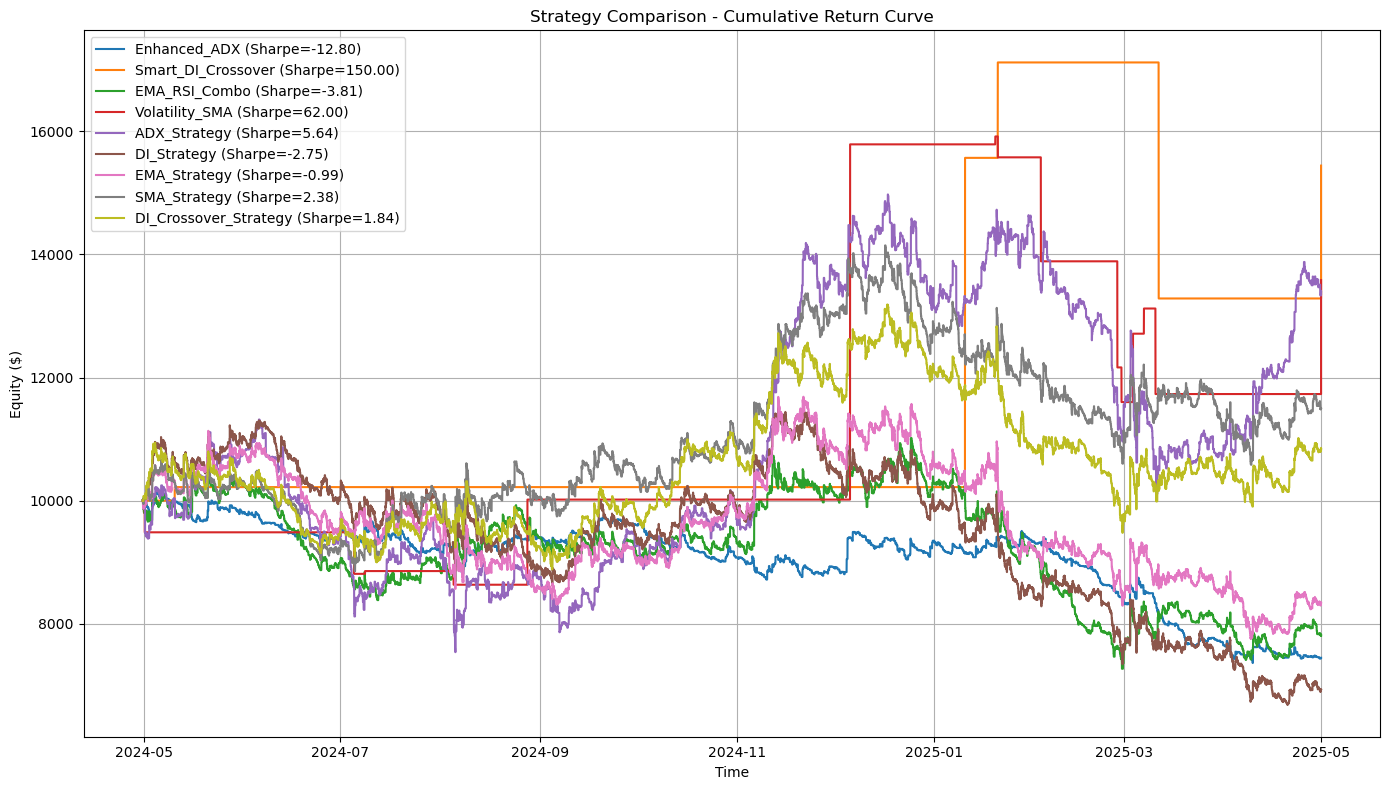

In [91]:
action_stats = {}

plt.figure(figsize=(14, 8))
for name, strat in strategies.items():

    signal = pd.Series(0, index=df.index)
    signal[strat['buy_cond']] = 1
    signal[strat['sell_cond']] = -1
    signal = signal.fillna(0)

    action_counts = signal.value_counts(normalize=True) * 100  # 百分比
    buy_ratio = action_counts.get(1, 0)
    sell_ratio = action_counts.get(-1, 0)
    hold_ratio = action_counts.get(0, 0)
    action_stats[name] = {
        'Buy %': buy_ratio,
        'Sell %': sell_ratio,
        'Hold %': hold_ratio
    }

    trades, curve, sharpe, mdd = backtest_strategy_full_scan(df, strat['buy_cond'], strat['sell_cond'])

    print(f"\n strategy: {name}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {mdd:.2%}")
    print(f"Number of trades: {len(trades)}")
    print(" First 50 transactions:")
    for _, row in trades.head(50).iterrows():
        print(f"Buy：{row['buy_time']}, Price：{row['buy_price']:.2f}")
        print(f"Sale：{row['sell_time']}, Price：{row['sell_price']:.2f}")

    plt.plot(curve.index, curve.values, label=f"{name} (Sharpe={sharpe:.2f})")

plt.title('Strategy Comparison - Cumulative Return Curve')
plt.xlabel('Time')
plt.ylabel('Equity ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
print("\n Distribution of signaling actions for each strategy（%）:")
action_df = pd.DataFrame(action_stats).T.round(2)
print(action_df)


 Distribution of signaling actions for each strategy（%）:
                       Buy %  Sell %  Hold %
Enhanced_ADX            2.23   60.30   37.47
Smart_DI_Crossover      6.30    0.00   93.70
EMA_RSI_Combo          13.04   31.53   55.42
Volatility_SMA          1.82    0.07   98.11
ADX_Strategy           36.18   11.00   52.82
DI_Strategy            49.83   50.16    0.00
EMA_Strategy           51.14   48.85    0.01
SMA_Strategy           51.71   48.26    0.03
DI_Crossover_Strategy  29.21   38.13   32.66
